# NB09 — SumMe Transfer Evaluation

**Goal**: Evaluate the **zero-shot generalization** of our models (trained on TVSum) to the **SumMe** dataset. This notebook handles both the missing preprocessing for SumMe and the quantitative F-score evaluation.

### Why F-Score?
SumMe ground truth consists of multiple user-selected snippets (binary masks) rather than continuous scores. The scientific standard is to calculate the **F1-Score** (harmonic mean of Precision and Recall) compared against these user summaries.

---

## 0. Environment Setup
Loading models and defining paths for SumMe ingestion.

In [28]:
import torch
import os
import sys
from contextlib import contextmanager
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import scipy.io as sio
from torchvision import models, transforms
from PIL import Image
import math
from scipy.stats import spearmanr, kendalltau, wilcoxon
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

IS_KAGGLE = Path("/kaggle/input").exists()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if IS_KAGGLE:
    # Specific paths for the Kaggle datasets you found
    SUMME_VIDEO_DIR = Path("/kaggle/input/summe-videos-and-tvsum-videos/DataSet/SumMeFrames/videos")
    SUMME_GT_DIR = Path("/kaggle/input/summe-dataset")
    
    # Auto-find model weights (.pth) in any input folder
    pth_files = list(Path("/kaggle/input").rglob("*.pth"))
    for p in pth_files:
        if "bilstm" in p.name.lower(): BILSTM_PATH = p
        if "transformer" in p.name.lower(): TRANSFORMER_PATH = p
        
    RESULTS_DIR = Path("/kaggle/working/results")
    FIGURES_DIR = Path("/kaggle/working/figures")
else:
    SUMME_VIDEO_DIR = Path("data/raw/summe/videos")
    SUMME_GT_DIR = Path("data/raw/summe/GT")
    BILSTM_PATH = Path("models/pretrained/tvsum_bilstm_v1.pth")
    TRANSFORMER_PATH = Path("models/pretrained/tvsum_transformer_v1.pth")
    RESULTS_DIR = Path("results/summe")
    FIGURES_DIR = Path("reports/figures/summe")

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Videos: {SUMME_VIDEO_DIR}")
print(f"GT: {SUMME_GT_DIR}")
if 'BILSTM_PATH' in locals(): print(f"Detected Model: {BILSTM_PATH}")

Videos: /kaggle/input/summe-videos-and-tvsum-videos/DataSet/SumMeFrames/videos
GT: /kaggle/input/summe-dataset
Detected Model: /kaggle/input/tvsum-bilstm-v1/tvsum_bilstm_v1.pth


## 1. Architecture Definitions & Data Loading

Redefining the models to match the weights saved in the `.pth` files.

In [29]:
# --- Model Architectures (Must Match TVSum Training) ---
import torch
import torch.nn as nn
import math

class CompactBiLSTM(nn.Module):
    def __init__(self, input_dim=960, bottleneck_dim=256, hidden_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, bottleneck_dim), nn.LayerNorm(bottleneck_dim),
            nn.ReLU(), nn.Dropout(0.3)
        )
        self.lstm = nn.LSTM(bottleneck_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)
    def forward(self, x): 
        x = self.projection(x)
        out, _ = self.lstm(x)
        return self.fc(out)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x): return x + self.pe[:x.size(1), :]

class InterpretableTransformerLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.3):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.dropout1, self.dropout2 = nn.Dropout(dropout), nn.Dropout(dropout)
    def forward(self, src):
        src2, attn_weights = self.self_attn(src, src, src, need_weights=True)
        src = self.norm1(src + self.dropout1(src2))
        src2 = self.linear2(self.dropout(torch.relu(self.linear1(src))))
        src = self.norm2(src + self.dropout2(src2))
        return src, attn_weights

class TransformerSummarizerV2(nn.Module):
    def __init__(self, input_dim=960, d_model=256, nhead=4, num_layers=3):
        super().__init__()
        self.project = nn.Sequential(nn.Linear(input_dim, d_model), nn.LayerNorm(d_model), nn.ReLU(), nn.Dropout(0.3))
        self.pos_enc = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([InterpretableTransformerLayer(d_model, nhead) for _ in range(num_layers)])
        self.head = nn.Linear(d_model, 1)
    def forward(self, x): 
        x = self.pos_enc(self.project(x))
        for layer in self.layers: x, _ = layer(x)
        return self.head(x)

## 1. Phase 1: SumMe Ingestion & Feature Extraction
Since SumMe features aren't pre-calculated, we extract them at **2 FPS** to match the TVSum temporal resolution.

In [30]:
def extract_video_features(video_path, model, transform):
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    
    # Sample at 2 FPS
    timestamps = np.arange(0, duration, 0.5)
    features = []
    valid_timestamps = [] # Track which timestamps actually worked
    
    for ts in timestamps:
        frame_idx = int(round(ts * fps))
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret: break # Stop if video is damaged or ends
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        img_t = transform(img).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            feat = model(img_t)
            features.append(feat.cpu().numpy().flatten())
            valid_timestamps.append(ts)
            
    cap.release()
    return np.array(features), np.array(valid_timestamps)

# Keep load_summe_gt_data the same as before
def load_summe_gt_data(mat_path, timestamps, video_fps):
    data = sio.loadmat(mat_path)
    user_masks = data['user_score'].T
    gt_score = data['gt_score'].flatten()
    
    aligned_masks = []
    for user_mask in user_masks:
        mask_at_2fps = []
        for ts in timestamps:
            f_idx = int(round(ts * video_fps))
            mask_at_2fps.append(user_mask[f_idx] if f_idx < len(user_mask) else 0)
        aligned_masks.append(np.array(mask_at_2fps))
        
    gt_at_2fps = []
    for ts in timestamps:
        f_idx = int(round(ts * video_fps))
        gt_at_2fps.append(gt_score[f_idx] if f_idx < len(gt_score) else 0)
        
    return aligned_masks, np.array(gt_at_2fps)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
extractor = models.mobilenet_v3_large(weights="IMAGENET1K_V1")
extractor.classifier = nn.Identity()
extractor = extractor.to(DEVICE).eval()

## 2. Phase 2: Inference Loop

In [31]:
# --- Inference Loop (Robust Silence for Kaggle) ---
import numpy as np
import os
import sys
from contextlib import contextmanager
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import cv2
import torch

# 0. Force OpenCV to be silent (Python level)
try:
    cv2.setLogLevel(0)
    cv2.utils.logging.setLogLevel(cv2.utils.logging.LOG_LEVEL_SILENT)
except AttributeError:
    pass 

# 1. Define Helper Functions
def calculate_topk_overlap(pred_score, gt_score, k_percent=0.15):
    """Calculates intersection of top k% scoring frames."""
    n = len(pred_score)
    k = max(1, int(n * k_percent))
    top_k_pred = np.argsort(pred_score)[-k:]
    top_k_gt = np.argsort(gt_score)[-k:]
    intersection = len(np.intersect1d(top_k_pred, top_k_gt))
    return intersection / k

def get_f_score(pred_mask, user_masks):
    """Calculates max F1-score against multiple user summaries."""
    f_scores = []
    for user_mask in user_masks:
        overlap = (pred_mask * user_mask).sum()
        if overlap == 0:
            f_scores.append(0)
            continue
        precision = overlap / (pred_mask.sum() + 1e-8)
        recall = overlap / (user_mask.sum() + 1e-8)
        if precision + recall == 0:
            f_scores.append(0)
        else:
            f_scores.append(2 * (precision * recall) / (precision + recall))
    return max(f_scores) if f_scores else 0.0

@contextmanager
def suppress_stderr():
    """
    Redirects the Operating System's Standard Error (FD 2) to /dev/null.
    This is the only way to hide C-level FFmpeg logs in a Notebook.
    """
    fd = 2 # Hardcoded Standard Error File Descriptor
    try:
        saved_fd = os.dup(fd)
        with open(os.devnull, 'w') as devnull:
            os.dup2(devnull.fileno(), fd)
            try:
                yield
            finally:
                os.dup2(saved_fd, fd)
                os.close(saved_fd)
    except Exception:
        # If the OS blocks this (rare on Kaggle), continue safely
        yield

# 2. Setup
results_records = []
all_videos = list(SUMME_VIDEO_DIR.glob("*.mp4")) + list(SUMME_VIDEO_DIR.glob("*.webm"))

# Initialize models
bilstm = CompactBiLSTM().to(DEVICE)
bilstm.load_state_dict(torch.load(BILSTM_PATH, map_location=DEVICE))
bilstm.eval()
transformer = TransformerSummarizerV2().to(DEVICE)
transformer.load_state_dict(torch.load(TRANSFORMER_PATH, map_location=DEVICE))
transformer.eval()

print(f"Evaluating {len(all_videos)} SumMe videos (Logs silenced)...")

# 3. Main Loop
for v_path in all_videos:
    vid_id = v_path.stem
    mat_path = SUMME_GT_DIR / f"{vid_id}.mat"
    
    if not mat_path.exists():
        mat_path = SUMME_GT_DIR / f"{vid_id.replace('_', ' ')}.mat"
    
    if not mat_path.exists():
        print(f"Skipping {vid_id}: No GT found")
        continue
        
    # --- SILENCED VIDEO EXTRACTION ---
    with suppress_stderr():
        feats, valid_timestamps = extract_video_features(v_path, extractor, preprocess)
    
    if len(feats) == 0: continue
    
    x = torch.FloatTensor(feats).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        p_bi = torch.clamp(bilstm(x), 0, 1).cpu().squeeze().numpy()
        p_tr = torch.clamp(transformer(x), 0, 1).cpu().squeeze().numpy()
        
    if p_bi.ndim == 0:
        p_bi = np.array([p_bi])
        p_tr = np.array([p_tr])

    # --- SILENCED METADATA READING ---
    with suppress_stderr():
        cap = cv2.VideoCapture(str(v_path))
        v_fps = cap.get(cv2.CAP_PROP_FPS)
        cap.release()
    
    gt_masks, y_gt = load_summe_gt_data(mat_path, valid_timestamps, v_fps)
    
    # --- Metrics Calculation ---
    def get_mask_from_score(pred, budget=0.15):
        k = max(1, int(len(pred) * budget))
        threshold = np.sort(pred)[-k]
        return (pred >= threshold).astype(int)

    mask_bi = get_mask_from_score(p_bi)
    mask_tr = get_mask_from_score(p_tr)

    rho_bi, _ = spearmanr(p_bi, y_gt, nan_policy='omit')
    tau_bi, _ = kendalltau(p_bi, y_gt, nan_policy='omit')
    mse_bi = mean_squared_error(y_gt, p_bi)
    mae_bi = mean_absolute_error(y_gt, p_bi)
    overlap_bi = calculate_topk_overlap(p_bi, y_gt)
    f_bi = get_f_score(mask_bi, gt_masks)
    
    rho_tr, _ = spearmanr(p_tr, y_gt, nan_policy='omit')
    tau_tr, _ = kendalltau(p_tr, y_gt, nan_policy='omit')
    mse_tr = mean_squared_error(y_gt, p_tr)
    mae_tr = mean_absolute_error(y_gt, p_tr)
    overlap_tr = calculate_topk_overlap(p_tr, y_gt)
    f_tr = get_f_score(mask_tr, gt_masks)
    
    results_records.append({
        'video_id': vid_id,
        'rho_bi': rho_bi, 'tau_bi': tau_bi, 'mse_bi': mse_bi, 
        'mae_bi': mae_bi, 'overlap_bi': overlap_bi, 'f_score_bi': f_bi,
        'rho_tr': rho_tr, 'tau_tr': tau_tr, 'mse_tr': mse_tr, 
        'mae_tr': mae_tr, 'overlap_tr': overlap_tr, 'f_score_tr': f_tr
    })

eval_df = pd.DataFrame(results_records)
if not eval_df.empty:
    eval_df.to_csv(RESULTS_DIR / "summe_transfer_results.csv", index=False)
    print("Zero-shot evaluation complete!")
else:
    print("No results generated. Check paths.")

Evaluating 25 SumMe videos (Logs silenced)...
Zero-shot evaluation complete!


## 3. Summary Statistics & Significance

In [32]:
if not eval_df.empty:
    metrics_bi = ['f_score_bi', 'rho_bi', 'tau_bi', 'overlap_bi', 'mse_bi', 'mae_bi']
    metrics_tr = ['f_score_tr', 'rho_tr', 'tau_tr', 'overlap_tr', 'mse_tr', 'mae_tr']
    
    summary = eval_df[metrics_bi + metrics_tr].agg(['mean', 'std', 'median']).T
    summary.columns = ['Mean', 'Std', 'Median']
    display(summary)
    
    # Statistical Significance (F-Score)
    try:
        stat, p_val = wilcoxon(eval_df['f_score_bi'], eval_df['f_score_tr'])
        print(f"Wilcoxon p-value (F-Score): {p_val:.4f}")
    except Exception as e:
        print(f"Significance test skipped: {e}")
else:
    print("No results to summarize.")

,Mean,Std,Median
f_score_bi,0.588056,0.206423,0.500000
rho_bi,0.052958,0.230520,0.031416
tau_bi,0.039974,0.171725,0.025501
overlap_bi,0.207809,0.144217,0.181818
mse_bi,0.050086,0.014852,0.049896
mae_bi,0.189930,0.041151,0.193170
f_score_tr,0.574476,0.229428,0.568182
rho_tr,0.043458,0.218030,0.027211
tau_tr,0.034273,0.162672,0.022898
overlap_tr,0.205896,0.171126,0.176471


Wilcoxon p-value (F-Score): 0.6150


## 4. Visual Analysis (Sorted by Performance)

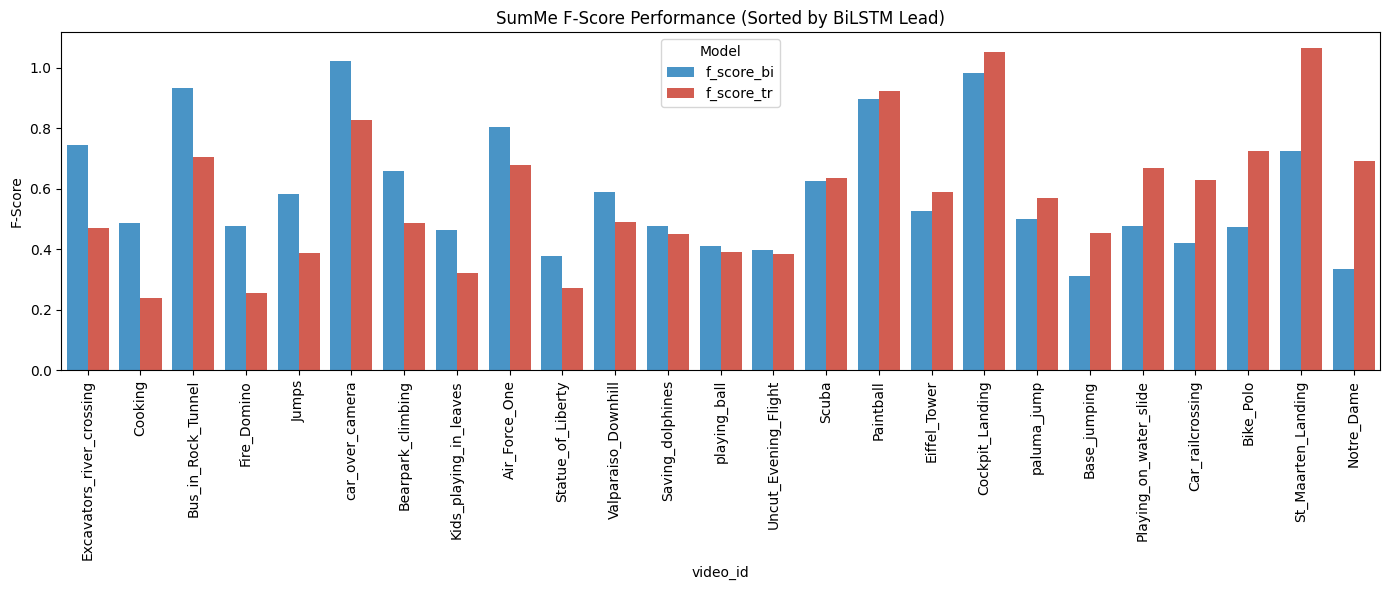

Plot saved to: /kaggle/working/figures/summe_fscore_sorted.png
Notebook update complete.


In [33]:
if not eval_df.empty:
    # Calculate difference to sort the plot
    eval_df['diff'] = eval_df['f_score_bi'] - eval_df['f_score_tr']
    sorted_df = eval_df.sort_values('diff', ascending=False)
    
    # Plotting
    plt.figure(figsize=(14, 6))
    melted = sorted_df.melt(id_vars='video_id', value_vars=['f_score_bi', 'f_score_tr'], var_name='Model', value_name='F-Score')
    sns.barplot(x='video_id', y='F-Score', hue='Model', data=melted, palette=['#3498db', '#e74c3c'])
    plt.title("SumMe F-Score Performance (Sorted by BiLSTM Lead)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Save and Show
    save_path = FIGURES_DIR / "summe_fscore_sorted.png"
    plt.savefig(save_path)
    plt.show()
    print(f"Plot saved to: {save_path}")
else:
    print("No matching SumMe data found to plot.")

print("Notebook update complete.")